# Bayesian regression, four ways

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Univariate normal distribution
Let's try to infer the most likely parameters of a normal distribution given some data ($y$).
We'll generate some data (of size $N = 100$) with known parameters $\mu = 0$ and $\sigma = 1$:

\begin{align}
y \sim N(0, 1)
\end{align}

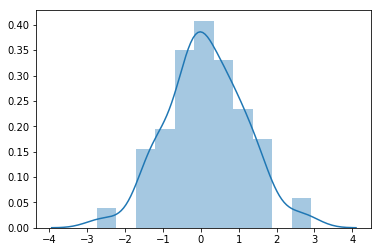

In [2]:
N = 100
y = np.random.normal(0, 1, size=N)

sns.distplot(y)

Now, the analytical (estimated) mean is calculated as:

\begin{align}
\bar{y} = \frac{1}{N}\sum_{i}^{N}y_{i} 
\end{align}

And the analytical standard deviation is calculated as:

\begin{align}
s = \frac{1}{N}\sum_{i}^{N}(y_{i} - \bar{y})^2
\end{align}

Let's do just that:

In [3]:
y_est_mean = np.mean(y)
y_est_sd = np.std(y)

print('Estimated mean: %.3f' % y_est_mean)
print('Estimated sd: %.3f' % y_est_sd)

Estimated mean: 0.127
Estimated sd: 1.026


Now, how about a bayesian estimation?

\begin{align}
p(\theta \mid y) \propto p(y \mid \theta)p(\theta)
\end{align}

Let's use completely flat priors to mimic the analytical solution:

In [4]:
model = pm.Model()

with model:
    
    mu = pm.Flat('mu')
    sigma = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
    trace_ndist = pm.sample(steps=10000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1663.96draws/s]


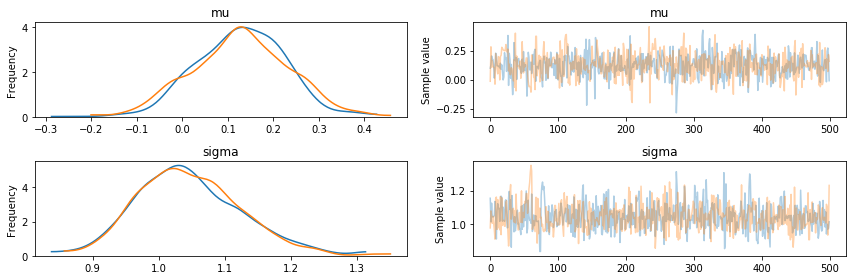

Estimated mean, bayesian: 0.126
Estimated sd, bayesian: 1.045


In [5]:
pm.traceplot(trace_ndist)
plt.show()

y_est_mean_bayes = np.mean(trace_ndist['mu'])
y_est_sd_bayes = np.mean(trace_ndist['sigma'])

print('Estimated mean, bayesian: %.3f' % y_est_mean_bayes)
print('Estimated sd, bayesian: %.3f' % y_est_sd_bayes)

Close enough!

## OLS regression
Now, let's also generate some independent variable, $X$, which we'll use to re-generate our $y$ variable:

\begin{align}
y = X\beta + \epsilon \sim N(0, 1)
\end{align}

In [6]:
X = np.random.normal(0, 1, size=N)
X = np.c_[np.ones(N), X]
epsilon = np.random.normal(0, 2, size=N)
betas = np.array([1, 2])
y = X.dot(betas) + epsilon

Now, let's first estimate the parameters ($\beta$) using the analytical version (OLS):

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

In [8]:
betas_ols = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
sigmasq_ols = np.sum((y - X.dot(betas_ols)) ** 2) / (N - 2)
covar_betas_ols = sigmasq_ols * np.linalg.inv(X.T.dot(X))
print('Estimated params, OLS: %s' % (betas_ols,))
print('Estimated sigma, OLS: %s' % (sigmasq_ols,))

covar_betas_ols

Estimated params, OLS: [1.20181465 1.93749168]
Estimated sigma, OLS: 4.172262106124318


array([[ 0.04179144, -0.00168261],
       [-0.00168261,  0.04113645]])

And the Bayesian way:

\begin{align}
y \sim N(X\beta, \sigma I)
\end{align}

In [9]:
ols_model = pm.Model()

with ols_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas_bayes), sd=sigma_bayes, observed=y)
    trace_ols = pm.sample(10000, cores=2)
    map_est = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:09<00:00, 2216.72draws/s]
logp = -226.12, ||grad|| = 0.2269: 100%|██████████| 26/26 [00:00<00:00, 1531.86it/s]         


In [10]:
betas_est_bayes = np.mean(trace_ols['betas'], axis=0)
sd_est_bayes = np.mean(trace_ols['sigma'])
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))

Estimated params, bayes: [1.20035934 1.93661467]
Estimated sd, bayes: 2.0686524009150404


Note that the (co)variance of the posterior distributions of the parameters ($\beta$) is (approximately) the same as the analytical (OLS) solution when assuming a flat prior over the parameters. 

In [11]:
np.cov(trace_ols['betas'].T)

array([[ 0.04264331, -0.00204655],
       [-0.00204655,  0.04304584]])

Also, it's actually quite easy to run a (bayesian) GLM with OLS-like likelihoods (Gaussian) and priors (flat) using the `glm` module of pymc3:

In [12]:
data = pd.DataFrame({'X1': X[:, 1], 'y': y})
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ X1', data=data,
                            family='normal',
                            priors=None)
    
    trace = pm.sample(2000, cores=2)

print(np.mean(trace['Intercept'], axis=0))
print(np.mean(trace['X1'], axis=0))
print(np.mean(trace['sd'], axis=0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, X1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2360.35draws/s]

1.2039436529790513
1.9373034619666962
2.0672485135667324


Same same!

## Ridge
To be continued!

Why on earth is the ridge analytical solution not the same as when specifing a normal
prior on the parameters with mean 0 and variance $\lambda^-1$?

In [19]:
X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
lambds = [0.1, 0.5, 1, 5, 10, 100]

b_ridge = np.zeros(6)
b_ridge_bayes = np.zeros(6)
for i, lambd in enumerate(lambds):
    b_ridge[i] = np.linalg.inv(X.T.dot(X) + lambd*np.eye(2)).dot(X.T).dot(y)[1]
    
    ridge_model = pm.Model()

    with ridge_model:
        betas = pm.Normal('betas', 0, lambd**-1, shape=2)
        sigma = pm.Uniform('sigma', lower=0, upper=10**6)
        y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sd=sigma, observed=y)
        b_ridge_bayes[i] = pm.find_MAP()['betas'][1]

logp = -232.59, ||grad|| = 0.57652: 100%|██████████| 24/24 [00:00<00:00, 2179.90it/s]         
logp = -230.02, ||grad|| = 0.45326: 100%|██████████| 25/25 [00:00<00:00, 1707.31it/s]         
logp = -230.58, ||grad|| = 0.36466: 100%|██████████| 24/24 [00:00<00:00, 1384.64it/s]         
logp = -5.5978e+17, ||grad|| = 1.1423e+18: 100%|██████████| 21/21 [00:00<00:00, 1976.31it/s]  
logp = -5.5978e+17, ||grad|| = 1.1423e+18: 100%|██████████| 20/20 [00:00<00:00, 2570.43it/s]  
logp = -5.5978e+17, ||grad|| = 1.1423e+18: 100%|██████████| 21/21 [00:00<00:00, 1998.01it/s]  


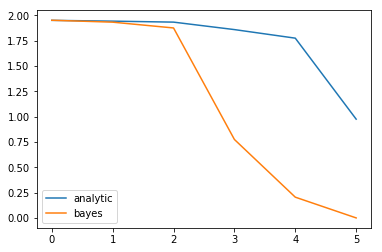

In [20]:
plt.plot(b_ridge)
plt.plot(b_ridge_b)
plt.legend(['analytic', 'bayes'])